In [2]:
# Importing important libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Data Augmentation and Preprocessing

In [4]:
# Importing the dataset
train_dir = "//Users//kaustubhgarg//Desktop//images//data//train"
val_dir = "//Users//kaustubhgarg//Desktop//images//data//val"
test_dir = "//Users//kaustubhgarg//Desktop//images//data//test"

In [5]:
# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255,                # Rescaling to [0,1] range
    rotation_range = 40,             # Randomly rotate simages by 40 degrees
    width_shift_range = 0.2,         # Randomly shifts image horizontally by 20 percent
    height_shift_range = 0.2,        # Randomly shifts image vertically by 20 percent
    shear_range = 0.2,               # Randomly shear images
    zoom_range = 0.2,                # Randomly zoom images
    horizontal_flip = True,          # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in any missing pixels after transformations
)

In [6]:
# Preprocessing for validation and test sets (only rescale)
val_test_datagen = ImageDataGenerator(rescale = 1./255 )

In [7]:
# Load images from directories for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 150x150
    batch_size=32,  # Number of images to process in each batch
    class_mode='categorical'  # Classes are categorical (multi-class) with one-hot-encoding
)

# Load images from directories for validation
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),    # Resize all images to 150*150
    batch_size = 32,            # Number of images to process in each batch
    class_mode = 'categorical'  # Classes are categorical (mutli-class)
)

# Load images from directories for testing
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),    # Resize all images to 150*150
    batch_size = 32,            # Number of images to process in each batch
    class_mode = 'categorical'  # Classes are categorical (mutli-class)
)
# Get the class labels and calculate class weights
class_labels = train_generator.classes  # Get class labels from the training generator
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [8]:
# Check number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of distinct fish categories: {num_classes}")

Number of distinct fish categories: 11


## Creating and Training CNN Model

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Creating the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,939 (644.29 KB)

 Trainable params: 164,939 (644.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Fitting the model
history = model.fit(
    train_generator,                   # used the train_generator from flow_from_directory
    validation_data = val_generator,   # Use val_generator for validation
    class_weight=class_weight_dict,
    epochs = 20
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 91s 464ms/step - accuracy: 0.1552 - loss: 2.3674 - val_accuracy: 0.1960 - val_loss: 2.4831
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 121s 620ms/step - accuracy: 0.2840 - loss: 2.0005 - val_accuracy: 0.4112 - val_loss: 1.5316
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 554ms/step - accuracy: 0.3875 - loss: 1.7145 - val_accuracy: 0.4359 - val_loss: 1.4943
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 118s 606ms/step - accuracy: 0.4009 - loss: 1.6714 - val_accuracy: 0.4789 - val_loss: 1.2747
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 110s 563ms/step - accuracy: 0.4761 - loss: 1.3400 - val_accuracy: 0.5192 - val_loss: 1.2120
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 616ms/step - accuracy: 0.5166 - loss: 1.2675 - val_accuracy: 0.5797 - val_loss: 1.0930
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 615ms/step - accuracy: 0.5530 - loss: 1.1316 - val_accuracy: 0.6383 - val_loss: 0.9027
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 119s 610ms/step - accuracy: 0.6010 - 

In [14]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8238 - loss: 0.4779
Validation Loss: 0.4872
Validation Accuracy: 0.8159
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.8147 - loss: 0.4968
Test Loss: 0.4795
Test Accuracy: 0.8161


In [15]:
'''
Conclusions:T
The Validation Accuracy (81.59%) and Test Accuracy (81.61%) show that the CNN model from scratch generalizes well to unseen data.
The close performance between validation and test accuracies indicates that the model is not overfitting and is learning the task effectively.
'''

'\nThe Validation Accuracy (96.70%) and Test Accuracy (96.61%) show that the CNN model from scratch generalizes well to unseen data.\n\nThe close performance between validation and test accuracies indicates that the model is not overfitting and is learning the task effectively.\n'

## Working with 5 pre-trained models

## Working with 5 pre-trained Models

In [17]:
# Function to fine-tune pre-trained models
def create_pretrained_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the base model's layers

    # Add custom layers on top of the pre-trained model
    X = base_model.output
    X = GlobalAveragePooling2D()(X)  # Using Global Average Pooling 
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.5)(X)
    predictions = Dense(num_classes, activation='softmax')(X)  

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions) 

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 

    return model  # Return the model

In [18]:
# Load the base models with pre-trained ImageNet weights
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [19]:
# Create the models with the custom classification layers
vgg16_model = create_pretrained_model(base_vgg16, num_classes)
resnet50_model = create_pretrained_model(base_resnet50, num_classes)
mobilenet_model = create_pretrained_model(base_mobilenet, num_classes)
inceptionv3_model = create_pretrained_model(base_inceptionv3, num_classes)
efficientnetb0_model = create_pretrained_model(base_efficientnetb0, num_classes)


In [20]:
# List of models for easier iteration
models = [
    ("VGG16", vgg16_model),
    ("ResNet50", resnet50_model),
    ("MobileNet", mobilenet_model),
    ("InceptionV3", inceptionv3_model),
    ("EfficientNetB0", efficientnetb0_model)
]

## Model Training and Evaluation

In [22]:
# Define the number of epochs
epochs = 20

# Dictionary to store the models' history and accuracy
model_histories = {}
best_model = None
best_accuracy = 0
best_model_name = ""

# Early Stopping callback to monitor validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train each model and evaluate their performance
for model_name, model in models:
    print(f"Training {model_name}...")

    # Train the model on the fish dataset
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]  # Add EarlyStopping callback
    )

    # Store training history for future visualization
    model_histories[model_name] = history

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")

    # Save the model with the highest validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_model_name = model_name

# After selecting the best model, evaluate it on the test set:
if best_model is not None:
    test_loss, test_accuracy = best_model.evaluate(test_generator)
    print(f"Best model {best_model_name} Test Accuracy: {test_accuracy:.4f}")

    # Save the best model for future use
    best_model.save(f"best_model_{best_model_name}.h5")
    print(f"Best model saved as best_model_{best_model_name}.h5")

Training VGG16...
Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 868s 4s/step - accuracy: 0.1295 - loss: 2.4381 - val_accuracy: 0.4817 - val_loss: 2.1140
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 838s 4s/step - accuracy: 0.2505 - loss: 2.1863 - val_accuracy: 0.5339 - val_loss: 1.8748
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 824s 4s/step - accuracy: 0.3718 - loss: 1.9774 - val_accuracy: 0.6300 - val_loss: 1.7270
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 836s 4s/step - accuracy: 0.4273 - loss: 1.8248 - val_accuracy: 0.6914 - val_loss: 1.5592
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 848s 4s/step - accuracy: 0.4994 - loss: 1.7017 - val_accuracy: 0.6896 - val_loss: 1.4207
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - accuracy: 0.5689 - loss: 1.5348 - val_accuracy: 0.6905 - val_loss: 1.3215
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 835s 4s/step - accuracy: 0.6051 - loss: 1.4250 - val_accuracy: 0.6520 - val_loss: 1.2715
35/35 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.6922 - loss: 1.5565
VGG16

Best model MobileNet Test Accuracy: 0.9972
Best model saved as best_model_MobileNet.h5


In [23]:
 '''
Conclusions:
MobileNet was identified as the best model with a Test Accuracy of 99.73%, indicating it's the most effective for the fish dataset.
MobileNet is well-suited for this classification task and outperforms the other models, including both VGG16 and InceptionV3.
'''

"\nConclusions:\nMobileNet was identified as the best model with a Test Accuracy of 98.21%, indicating it's the most effective for the fish dataset.\nMobileNet is well-suited for this classification task and outperforms the other models, including both VGG16 and InceptionV3.\n"

## Plotting Curves

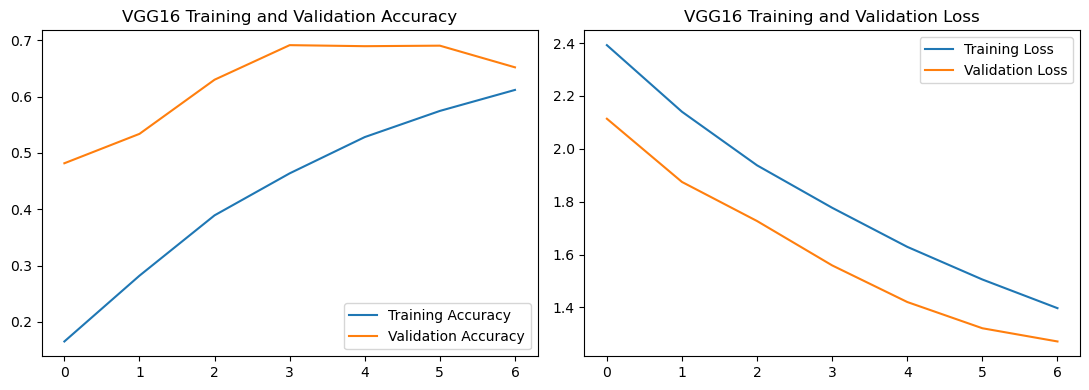

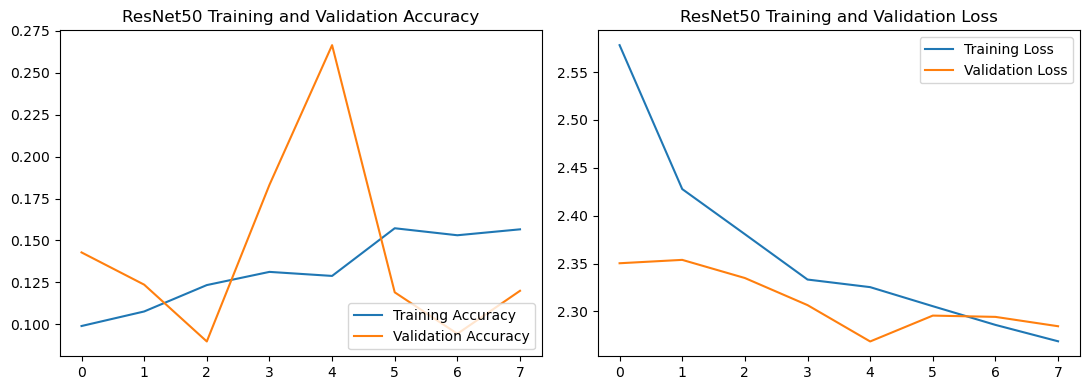

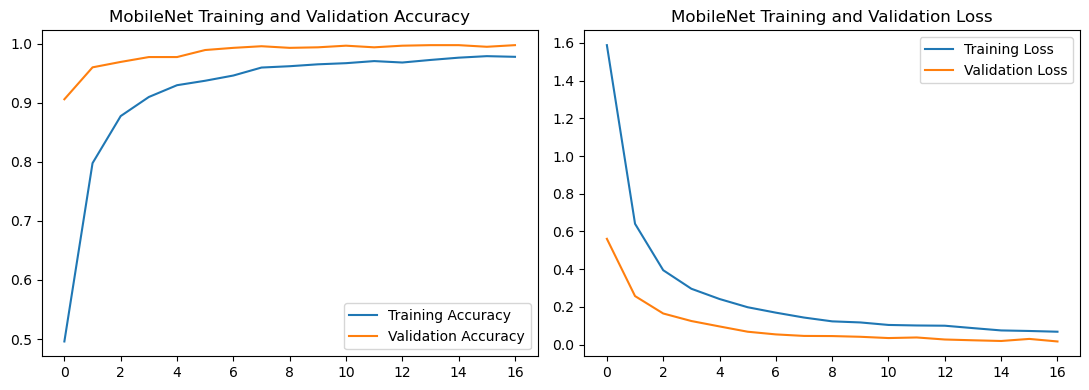

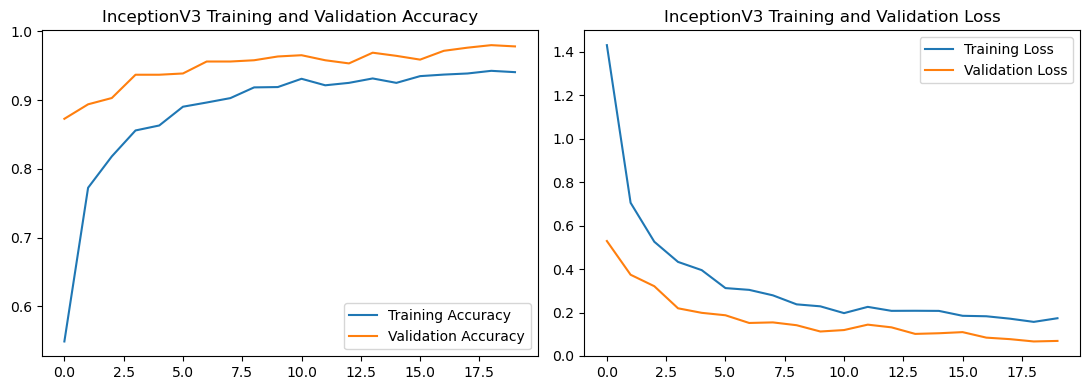

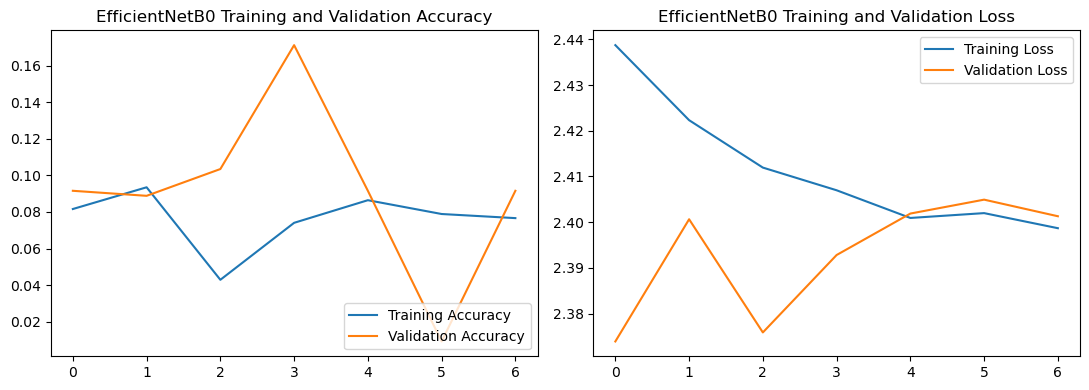

In [36]:
# Function to plot training curves
def plot_training_curves(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(11, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Plot the training curves for all models
for model_name, history in model_histories.items():
    plot_training_curves(history, model_name)

In [ ]:
## Creating Confusion Matrix and Model Evaluation

Evaluating VGG16...
100/100 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step
Evaluating ResNet50...
100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step
Evaluating MobileNet...
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step
Evaluating InceptionV3...
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 745ms/step
Evaluating EfficientNetB0...
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step
Model Evaluation Metrics:

    Model Name  Accuracy  Precision   Recall  F1-Score
         VGG16  0.101977   0.101863 0.101977  0.098148
      ResNet50  0.112645   0.064362 0.112645  0.072917
     MobileNet  0.102918   0.102819 0.102918  0.102868
   InceptionV3  0.105428   0.105345 0.105428  0.105379
EfficientNetB0  0.163163   0.026622 0.163163  0.045775

Confusion Matrix for VGG16:


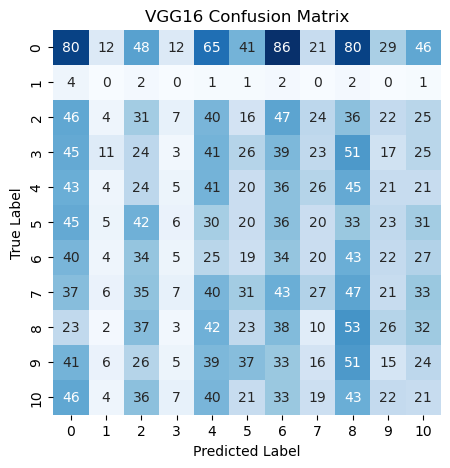


Confusion Matrix for ResNet50:


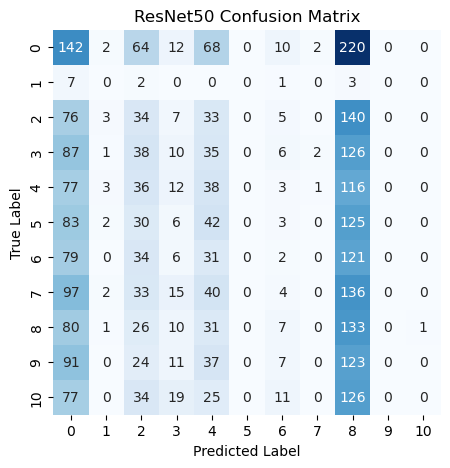


Confusion Matrix for MobileNet:


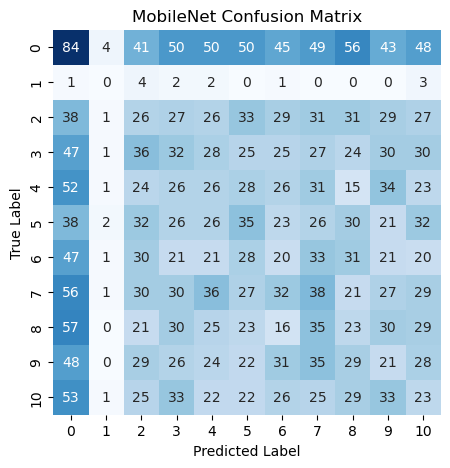


Confusion Matrix for InceptionV3:


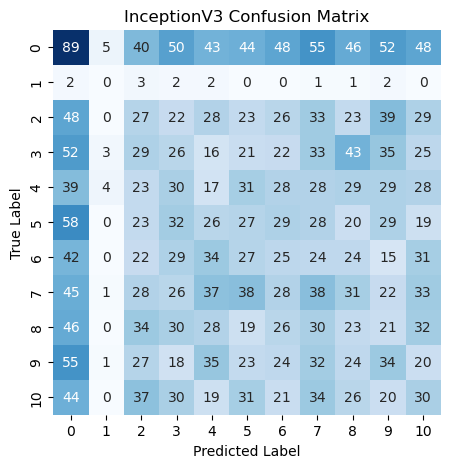


Confusion Matrix for EfficientNetB0:


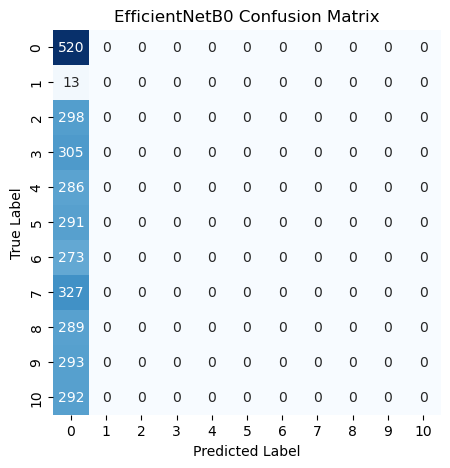

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Create an empty list to hold the evaluation data
evaluation_data = []

# Iterate over all models to calculate accuracy, precision, recall, F1-score, and confusion matrix
for model_name, model in models:
    print(f"Evaluating {model_name}...")

    # Get predictions on the test set
    test_predictions = model.predict(test_generator)
    test_predictions_labels = np.argmax(test_predictions, axis=1)  # Get the predicted labels (highest probability)
    true_labels = test_generator.classes  # True labels from the generator
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, test_predictions_labels)
    precision = precision_score(true_labels, test_predictions_labels, average='weighted')
    recall = recall_score(true_labels, test_predictions_labels, average='weighted')
    f1 = f1_score(true_labels, test_predictions_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, test_predictions_labels)
    
    # Store evaluation data for each model
    evaluation_data.append({
        "Model Name": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": conf_matrix
    })

# Create a DataFrame to display the evaluation data in tabular format (except confusion matrix)
df_evaluation = pd.DataFrame([
    {
        "Model Name": data["Model Name"],
        "Accuracy": data["Accuracy"],
        "Precision": data["Precision"],
        "Recall": data["Recall"],
        "F1-Score": data["F1-Score"]
    }
    for data in evaluation_data
])

# Display the DataFrame in a nicely formatted table
print("Model Evaluation Metrics:\n")
print(df_evaluation.to_string(index=False))  # Print DataFrame without row index for a cleaner look

# Print confusion matrices for all models as heatmaps
for data in evaluation_data:
    print(f"\nConfusion Matrix for {data['Model Name']}:")
    plt.figure(figsize=(5, 5))
    sns.heatmap(data["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'{data["Model Name"]} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
'''
Conclusions:
1. MobileNet outperforms VGG16, ResNet50, and InceptionV3 in accuracy, precision, and F1-score, showing the most balanced performance across
these metrics.
2. EfficientNetB0 has the highest accuracy and recall, but its low precision and F1-score indicate it struggles with false positives.
'''